In [2]:
from pathlib import Path
import os
import pandas as pd
import torch as tc
import torchvision as tv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary as ts
import numpy as np

In [3]:
input_file = Path(r"C:/Users/Michał/Documents/SI/resources/beer_labels.zip") # Path to the "beer_labels.zip"
output_folder = Path(r"C:/Users/Michał/Documents/SI/workdir/beer_labels") # Path to the folder where to unzip the input ".zip" file


print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

dataset_path = Path("C:/Users/Michał/Documents/SI/workdir/")
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = []
for name in os.listdir(output_folder):
    if os.path.isdir(os.path.join(output_folder, name)):
        classes.append(name)

print(classes)

Input file path: C:\Users\Michał\Documents\SI\resources\beer_labels.zip
Output folder path: C:\Users\Michał\Documents\SI\workdir\beer_labels
['5901549250329', '5901549250756', '5902448150178', '5902528052347', '5902528442230', '5902528443251', '5902528462337', '5902528473449', '5902528523311', '5902528573354', '5902528999994', '5902627011481', '5902705000871', '5902705001045', '5902931900112', '5902931900310', '5902931900419', '5903031401516', '5903111989811', '5903111989835', '5903111989873', '5903240620142', '5903240674145', '5903240674527', '5903292264004', '5903292264455', '5904730284004', '5904730284028', '5904730284035', '5904730284561', '5904730284660', '5904730290067', '5904730290074', '5904730438001', '5904730438575', '5904730438582', '5904730438605', '5904730465243', '5905279156067', '5905279213005', '5905279213210', '5905279213272', '5905279326224', '5905279326262', '5905279533240', '5905279533264', '5905279959521', '5905279959637', '5905279959743', '5905279965102', '5905279

In [4]:
all_cases = []

for current_class in classes:
    class_path = os.path.join(output_folder, current_class)
    image_files = os.listdir(class_path)

    for i in range(len(image_files)):
        image_path = os.path.join(class_path, image_files[i])
        all_cases.append((image_path,  current_class))
      
train_cases, test_cases = train_test_split(all_cases, test_size=0.2, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.125, random_state=42)

train_df = pd.DataFrame(train_cases, columns=["image_path", "image_class_name"])
train_df.to_csv(training_csv_path)

val_df = pd.DataFrame(val_cases, columns=["image_path", "image_class_name"])
val_df.to_csv(validation_csv_path)

test_df = pd.DataFrame(test_cases, columns=["image_path", "image_class_name"])
test_df.to_csv(testing_csv_path)


In [5]:
class BeerDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.at[idx, 'image_path']
        current_image = tv.io.read_image(image_path)
        current_class = self.dataframe.at[idx, 'image_class_name']

        current_image = tv.transforms.functional.resize(current_image, (224,224), antialias=True)
        current_image = current_image.float() / 255.0
        current_image = (current_image - 0.5) / 0.5
        
        return current_image, current_class

In [6]:
batch_size = 16
shuffle = True
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

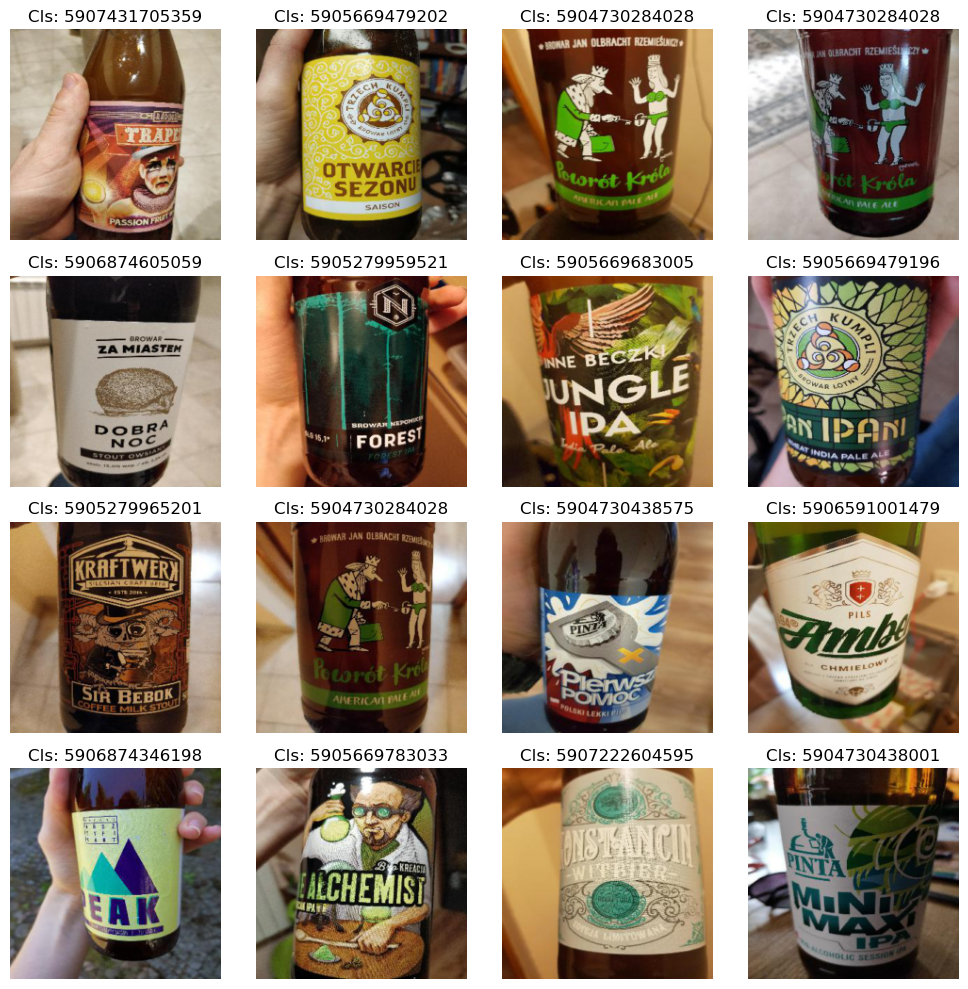

In [7]:
for images, classes in training_dataloader:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image + 1) / 2
        ax.set_title("Cls: " + str(classes[i].item()))
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [8]:
class ClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(32, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 100)  # change output classes = 100
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [10]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
#device = "cpu"

print("Device: " + device)

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[-0.0729,  0.0413,  0.0540, -0.1027,  0.0313,  0.0160, -0.1765,  0.0601,
          0.1202,  0.1198, -0.1452,  0.0135, -0.0449, -0.0585,  0.1529, -0.0441,
         -0.1975, -0.0950,  0.0714,  0.0272, -0.2178, -0.1288, -0.0663,  0.0918,
         -0.1903, -0.0436, -0.0253, -0.0022,  0.0118,  0.0785,  0.1384,  0.0827,
          0.0353, -0.1714,  0.0347, -0.0932,  0.0561,  0.0907,  0.0396, -0.0767,
          0.1487, -0.0994,  0.1212,  0.0471,  0.0432, -0.1624, -0.1321,  0.0424,
          0.0590,  0.0290,  0.0008,  0.0957,  0.0646,  0.0041,  0.0486,  0.2002,
          0.0717,  0.0385,  0.0631,  0.1059, -0.0195,  0.0383, -0.1630,  0.0761,
          0.1106, -0.0169,  0.0329, -0.0514,  0.0020,  0.0698, -0.1043, -0.0217,
         -0.0334, -0.0141, -0.1547,  0.2478, -0.1182, -0.0420,  0.0701, -0.1690,
          0.0202,  0.0450, -0.0716,  0.0035,  0.1131,  0

In [ ]:
class ImprovedClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ImprovedClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, 2, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, 1, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 256, 3, 2, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 256, 3, 1, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 512, 3, 2, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.Conv2d(512, 512, 3, 1, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [ ]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

improved_classification_network = ImprovedClassificationNetwork()
batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = improved_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(improved_classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[-7.3036e-02,  7.2729e-01, -2.6268e-01, -3.8098e-01, -2.2603e-01,
          2.0437e-01,  3.9682e-01, -7.2427e-01, -3.2379e-01,  7.4719e-01,
         -1.0903e+00,  1.0338e-01, -6.4192e-01,  6.2009e-01,  1.1217e-01,
         -5.6530e-01,  7.8003e-01, -6.9680e-01,  2.2371e-01,  2.2824e-01,
         -1.5786e-01,  2.6307e-01,  6.3529e-01, -3.8884e-01,  1.0664e+00,
         -1.9753e-02,  1.4150e-01,  4.3564e-01, -6.7365e-02, -6.3685e-02,
         -2.8775e-01, -4.6492e-01,  7.5287e-01, -2.6436e-01,  4.5525e-01,
          7.7119e-01,  3.9292e-02,  8.3430e-01, -7.4880e-03,  1.2298e-01,
         -5.9515e-01,  9.1090e-01,  4.2627e-01,  3.7042e-01, -7.3510e-01,
         -2.4930e-01, -1.5225e-01,  7.2504e-02,  2.6252e-01,  4.0880e-01,
          3.8797e-01, -3.5593e-01,  1.5305e-01, -6.3421e-01,  1.8325e+00,
          1.2333e-01, -6.6671e-02, -1.6642e-01,  3.1

In [15]:
def training(model, training_dataloader, testing_dataloader, num_epochs, learning_rate):
  
  objective_function = tc.nn.CrossEntropyLoss() 
  parameters = model.parameters() 
  optimizer = tc.optim.Adam(parameters, learning_rate) 
  device = "cuda:0" if tc.cuda.is_available() else "cpu" 
  #device = 'cpu'
  training_losses = []
  testing_losses = [] 
  model = model.to(device)
  
  print(f"Training dataset size: {len(training_dataloader.dataset)}")
  print(f"Testing dataset size: {len(testing_dataloader.dataset)}")
  for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")

    training_epoch_loss = 0.0
    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_epoch_loss += loss.item() * images.size(0)

    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    print(f"Current epoch training loss: {training_epoch_loss}")

    testing_epoch_loss = 0.0
    model.eval()
    for images, classes in testing_dataloader:
      with tc.set_grad_enabled(False):
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        testing_epoch_loss += loss.item() * images.size(0)

    testing_epoch_loss = testing_epoch_loss / len(testing_dataloader.dataset)
    testing_losses.append(testing_epoch_loss)
    print(f"Current epoch testing loss: {testing_epoch_loss}")

  # Return the trained model and the history of training and testing losses
  return model, training_losses, testing_losses

In [13]:
learning_rate = 0.002
batch_size = 16
num_epochs = 5
shuffle = True
transforms = tc.nn.Sequential(
  tv.transforms.RandomRotation(20),
)

#Trainig dataset/dataloader
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = BeerDataset(os.path.join(dataset_path, "Validation"), validation_csv_path)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = BeerDataset(os.path.join(dataset_path, "Testing"), testing_csv_path)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [16]:
classification_model, training_losses, testing_losses = training(classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
